In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# <center> Credit Default Competition <center>

> <center> Geekbrains Python for Data Science Course (Part 2) Competition <center>

### Plan

* Competition
    * Description
    * Evaluation
* Practice
    * Preparation
        * Data Upload
        * Definition of Classes and Functions
        * Features
        * Data Preparation
    * Model Training
    * Feature Importances
* Submission

## <center> Competition <center>

### Description

In this competition the task is to predict the Credit Default in test.csv. We are given two datasets: train.csv (contains all features and Credit Default) and test.csv (only features)

### Evaluation

The evaluation metric for this competition is Mean F1-Score

<center>$\large F1 = 2\LARGE \frac{p \: * \: r}{p \: + \: r} \:\: \small where \:\: \large p = \LARGE \frac{tp}{tp \: + \: fp}, \:\:\:\:\: \large r = \LARGE \frac{tp}{tp \: + \: fn}$<center>

The F1 metric weights recall and precision equally, and a good retrieval algorithm will maximize both precision and recall simultaneously. Thus, moderately good performance on both will be favored over extremely good performance on one and poor performance on the other.

## <center> Practice <center>

## Preparation

**Connecting libraries and scripts**

In [1]:
# functional

import pandas as pd
import numpy as np
import pickle

# sklearn

# model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# linear_model
from sklearn.linear_model import LogisticRegression

# neighbors
from sklearn.neighbors import KNeighborsClassifier

# metrics
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# gb

import xgboost as xgb
import lightgbm as lgbm
import catboost as catb

# visualization

import seaborn as sns
from matplotlib import pyplot as plt

# params
%matplotlib inline

**Warnings**

In [2]:
# dealing with warnings

import warnings
warnings.simplefilter('ignore')

### Data Upload

In [3]:
TRAIN_DATASET_PATH = '/kaggle/input/gb-credit-default/train.csv'
TEST_DATASET_PATH = '/kaggle/input/gb-credit-default/test.csv'

#### Dataset description

* **Home Ownership** - mortgage, rent or other
* **Annual Income** - annual income of the particular person
* **Years in current job** - years worked in that particular company
* **Tax Liens** - if any liens outstanding
* **Number of Open Accounts** - accounts opened
* **Years of Credit History** - for how long the records are available
* **Maximum Open Credit** - biggest credit ever had
* **Number of Credit Problems** - number of the problems occured while repaying the credit
* **Months since last delinquent** - number of months since the last payment was missing
* **Bankruptcies** - how many bankruptcies has this person
* **Purpose** - the reason why this credit was taken
* **Term** - for how long
* **Current Loan Amount** - what is the current sum of the loan
* **Current Credit Balance** - current credit
* **Monthly Debt** - how much is the monthly payment
* **Credit Score** - score
* **Credit Default** - either the credit was repaid on time (0) or delayed (1)

### Definition of Classes and Functions

In [5]:
# function to get the classification report

def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    
    report = {'train_report': classification_report(y_train_true, y_train_pred),
             'test_report': classification_report(y_test_true, y_test_pred),
             'crosstab': pd.crosstab(y_test_true, y_test_pred)}
    
    return report

**Class DataPrep**

In [13]:
class DataPrep:
    
    def __init__(self, path_to_file):
        
        self.current_loan_amount_median = 0
        self.add_dummies_columns = None
        self.df = pd.read_csv(path_to_file)
        
    def get_loan_amount_median(self):
        
        return self.df[self.df['Current Loan Amount'] <= 9999999.0]['Current Loan Amount'].mean()
    
    def get_default_annual_income(self):
        
        annual_income = self.df[self.df['Annual Income'] != 0]['Annual Income']
        
        return (2 * annual_income.mean() + 3 * annual_income.min()) / 5
    
    def transform(self, current_loan_ammount_median, default_annual_income):
        
        df = self.df.copy()
        add_dummies_columns = None
        
        # convert Years_in_current_job column to numbers from 0 to 3
        YICJ_to_numbers = {'< 1 year': '0', 
                           '1 year': '1', 
                           '2 years': '1', 
                           '3 years': '1', 
                          '4 years': '1', 
                          '5 years': '2', 
                          '6 years': '2', 
                          '7 years': '2', 
                          '8 years': '3', 
                          '9 years': '3',
                          'Years in current job_10+ years':'3'}
        
        # convert Purpose column to other
        df.loc[df['Purpose'] == 'buy a car', 'Purpose'] = 'other'
        df.loc[df['Purpose'] == 'buy house', 'Purpose'] = 'other'
        df.loc[df['Purpose'] == 'home improvements', 'Purpose'] = 'other'
        df.loc[df['Purpose'] == 'renewable energy', 'Purpose'] = 'other'
        
        # convert Annual Income
        df.loc[df['Annual Income'] == 0, 'Current Loan Amount'] = default_annual_income
        
        # convert Credit Score
        df.loc[df['Credit Score'] >= 3000, 'Credit Score'] = (df['Credit Score'] / 10)
        
        # convert Current Loan Amount
        df.loc[df['Current Loan Amount'] >= 9999999.0, 'Current Loan Amount'] = current_loan_amount_median
        
        # create new column based on Current Loan Amount
        df['TooBigLoanAmount'] = 1 * (df['Current Loan Amount'] > 9999999.0)
        
        # fill in the NaNs
        df['Annual Income'].fillna(0.0, inplace = True)
        df['Home Ownership'].fillna('Rent', inplace = True)
        df['Years in current job'].fillna('3 years', inplace = True)
        df['Bankruptcies'].fillna(0.0, inplace = True)
        df['Months since last delinquent'].fillna(0.0, inplace = True)
        df['Credit Score'].fillna(1000.0, inplace = True)
        
        # convert further column
        df['CreditScoreUnknown'] = 1 * (df['Credit Score'] == 0.0)
        df.loc[df['Bankruptcies'] >= 3, 'Bankruptcies'] = 3
        df['Years in current job'] = df['Years in current job'].map(YICJ_to_numbers)
        
        # dealing with columns & Dummies
        columns_old = set(df.columns.tolist())
        df = pd.get_dummies(df, columns = ['Home Ownership','Purpose'])
        
        columns_current = set(df.columns.tolist())
        df = pd.get_dummies(df, columns = ['Term', 'Years in current job'])
        
        columns_new = set(df.columns.tolist())
        
        for col in list(columns_new - columns_current):
            df[col] = df[col] * df['Current Loan Amount']
            df['CS' + col] = df[col] * df['Credit Score']
            
        columns_new = set(df.columns.tolist())
        self.add_dummies_columns = list(columns_new - columns_old)
        
        return df

In [7]:
# function to balance the df by target

def balance_df_by_target(df, target_name):
    
    target_counts = df[target_name].value_counts()
    
    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()
    
    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    
    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index = True)
        
        return df.sample(frac = 1)

**Class TrainModel**

In [9]:
class TrainModel:
    
    def __init__(self, X, y, target_name):
        
        model = None
        classification_report = None
        X_train, self.X_test, y_train, self.y_test = train_test_split(X, y, shuffle = True, test_size = 0.21, random_state = 79)
        df_for_balancing = pd.concat([X_train, y_train], axis = 1)
        df_balanced = balance_df_by_target(df_for_balancing, target_name)
        self.X_train = df_balanced.drop(columns = target_name)
        self.y_train = df_balanced[target_name]
        
    def log_regression(self, X):
        
        # define log_regression
        
        self.model = LogisticRegression()
        self.model.fit(self.X_train, self.y_train)

        y_train_pred = self.model.predict(self.X_train)
        y_test_pred = self.model.predict(self.X_test)

        self.classification_report = get_classification_report(self.y_train, y_train_pred, self.y_test, y_test_pred)
        
        return self.model.predict(X)
    
    def knn(self, X):
        
        # define K Neighbors
        
        self.model = KNeighborsClassifier()
        self.model.fit(self.X_train, self.y_train)

        y_train_pred = self.model.predict(self.X_train)
        y_test_pred = self.model.predict(self.X_test)

        self.classification_report = get_classification_report(self.y_train, y_train_pred, self.y_test, y_test_pred)
        
        return self.model.predict(X)
    
    def xgb(self, X, r_state):
        
        # define XGBoost
        
        self.model = xgb.XGBClassifier(random_state = r_state)
        self.model.fit(self.X_train, self.y_train)

        y_train_pred = self.model.predict(self.X_train)
        y_test_pred = self.model.predict(self.X_test)

        self.classification_report = get_classification_report(self.y_train, y_train_pred, self.y_test, y_test_pred)
        
        return self.model.predict(X)
    
    def lgbm(self, X, r_state):
        
        # define LGBM
        
        self.model = lgbm.LGBMClassifier(random_state = r_state)
        self.model.fit(self.X_train, self.y_train)

        y_train_pred = self.model.predict(self.X_train)
        y_test_pred = self.model.predict(self.X_test)

        self.classification_report = get_classification_report(self.y_train, y_train_pred, self.y_test, y_test_pred)
        
        return self.model.predict(X)
    
    def cat_boost(self, X, r_state, n_est, m_depth, cw):
        
        # define catboost
        
        self.model = catb.CatBoostClassifier(random_state = r_state, silent = True, n_estimators = n_est, max_depth = m_depth, class_weights = cw)
        self.model.fit(self.X_train, self.y_train)

        y_train_pred = self.model.predict(self.X_train)
        y_test_pred = self.model.predict(self.X_test)

        self.classification_report = get_classification_report(self.y_train, y_train_pred, self.y_test, y_test_pred)
        
        return self.model.predict(X)

### Features

In [8]:
# numerical features

numerical_features = ['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent', 'Current Credit Balance', 'Monthly Debt', 'Credit Score', 'TooBigLoanAmount', 'CreditScoreUnknown']

# target feature

target = 'Credit Default'

### Data Preparation

**Train**

In [15]:
# import the train data and apply class DataPrep

train_data_prep = DataPrep(TRAIN_DATASET_PATH)

# call median amount

current_loan_amount_median = train_data_prep.get_loan_amount_median()

# call default annual income

default_annual_income = train_data_prep.get_default_annual_income()

# call transform and change the df

train_df = train_data_prep.transform(current_loan_amount_median, default_annual_income)

# columns in train

train_df.columns
train_df = train_df[train_data_prep.add_dummies_columns + numerical_features + [target]]

**Test**

In [16]:
# import the test data and apply class DataPrep

test_data_prep = DataPrep(TEST_DATASET_PATH)

# call transform and change the df

test_df = test_data_prep.transform(current_loan_amount_median, default_annual_income)

test_df = test_df[test_data_prep.add_dummies_columns + numerical_features]

## Model Training

In [17]:
# apply class TrainModel

model_train = TrainModel(train_df[train_data_prep.add_dummies_columns + numerical_features], train_df[target], target)

# get the predictions

predictions = model_train.cat_boost(test_df, r_state = 167, n_est = 33, m_depth = 3, cw = [1, 1.07])

# print out the results

print('Train\n\n' + model_train.classification_report['train_report'])
print('Test\n\n' + model_train.classification_report['test_report'])
print('Confusion matrix\n')
print(model_train.classification_report['crosstab'])

Train

              precision    recall  f1-score   support

           0       0.73      0.72      0.73      4271
           1       0.65      0.65      0.65      3308

    accuracy                           0.69      7579
   macro avg       0.69      0.69      0.69      7579
weighted avg       0.69      0.69      0.69      7579

Test

              precision    recall  f1-score   support

           0       0.78      0.71      0.74      1116
           1       0.42      0.51      0.46       459

    accuracy                           0.65      1575
   macro avg       0.60      0.61      0.60      1575
weighted avg       0.67      0.65      0.66      1575

Confusion matrix

col_0             0    1
Credit Default          
0               791  325
1               224  235


## Feature importances

In [18]:
def show_feature_importances(feature_names, feature_importances, get_top = None):
    
    feature_importances = pd.DataFrame({'feature': feature_names,
                                       'importance': feature_importances})
    
    feature_importances = feature_importances.sort_values('importance', ascending = False)
    
    # plot the feature_importances
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

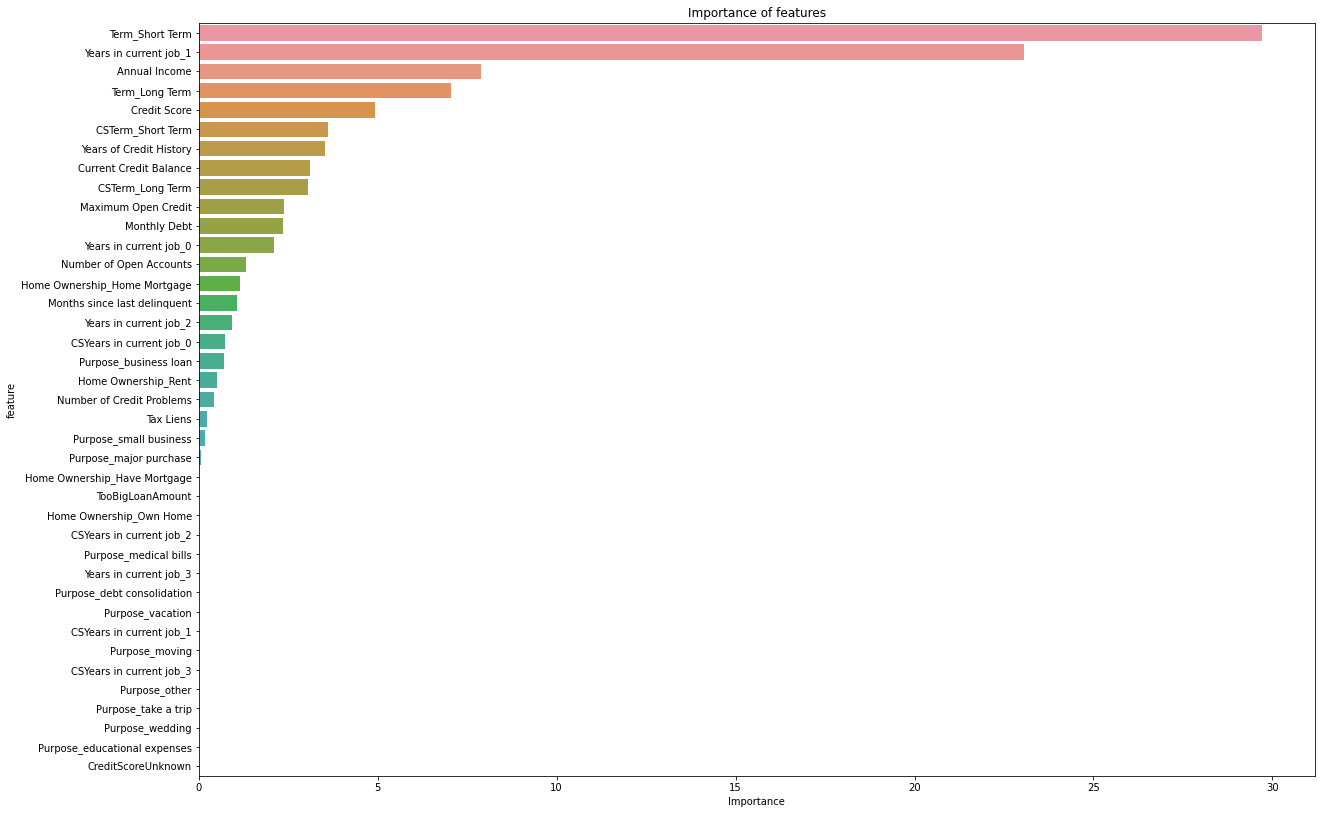

In [20]:
# plot the graph

important_features_top = show_feature_importances(model_train.X_train.columns, model_train.model.feature_importances_, get_top = 10)

## <center> Submission <center>

In [22]:
# read the csv

submit = pd.read_csv('/kaggle/input/gb-credit-default/sample_submission.csv')
submit['Credit Default'] = predictions

# export the csv

submit.to_csv('rf_submit.csv', index = False)

submit

,Id,Credit Default
0,0,1
1,1,1
2,2,1
3,3,0
4,4,1
...,...,...
2495,2495,0
2496,2496,1
2497,2497,1
2498,2498,1
